# Minplus algebra experiment

This code attempts to learn a Laplacian prior 
$J(x) = min(\frac{1}{2t\sigma_{1}}(x-\mu_{1})^{2}, \frac{1}{2\sigma_{2}}(x-\mu_{2}^{2})^{2})$
assuming we have access to a bunch of observations S(yi) = min_{x \in \R} 0.5*||x-yi||^{2}_{2} + J(x).

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

# Parameters and auxiliary functions

In [28]:
# Dimension of the LPN
dim = 1

# Parameters
mu1 = 1.0
mu2 = 2.0
sigma1 = 1.0
sigma2 = 1.0

# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1.0

def cvx_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(y-mu1,2)/(1+sigma1)
    val2 = 0.5*pow(y-mu2,2)/(1+sigma2)
    val = 0.5*pow(y,2) - np.minimum(val1,val2)
    return val

def prior_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(y-mu1,2)/sigma1
    val2 = 0.5*pow(y-mu2,2)/sigma2
    val = np.minimum(val1,val2)
    return val

def prox_true(y,mu1,mu2,sigma1,sigma2):
    val1 = 0.5*pow(y-mu1,2)/(1+sigma1)
    val2 = 0.5*pow(y-mu2,2)/(1+sigma2)
    val = (mu1 + sigma1*y)*(val1 <= val2)/(1 + sigma1) + (mu2 + sigma2*y)*(val1 > val2)/(1+sigma2)
    return val


# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)
    
    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, prox_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c, "-", ms=5, label="Cvx func")
    plt.plot(xi, cvx_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p, label="LPN")
    plt.plot(xi, prior_true(xi,mu1,mu2,sigma1,sigma2), "--", label="ref", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()


## Model parameters

In [29]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# Generate sample points uniformly in the interval [a,b]
bsize = 200
a = -5.0
b = 5.0

input = torch.distributions.uniform.Uniform(a, b, validate_args=None).sample((bsize,))
input = input.unsqueeze(1).to(device)

# Evaluate the solution of the HJ PDE at these points
# Convert to pytorch
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2)

## Training function

In [30]:
def single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 20.006961822509766
iteration 0 loss 94.7807388305664
iteration 500 loss 2.6981818675994873
iteration 1000 loss 1.2440789937973022
iteration 1500 loss 0.9258800745010376
iteration 2000 loss 0.7732841372489929
iteration 2500 loss 0.6408006548881531
iteration 3000 loss 0.4914771020412445
iteration 3500 loss 0.3356077969074249
iteration 4000 loss 0.19646479189395905
iteration 4500 loss 0.09783178567886353
iteration 5000 loss 0.05069230496883392
iteration 5500 loss 0.02972363494336605
iteration 6000 loss 0.01949048601090908
iteration 6500 loss 0.013607428409159184
iteration 7000 loss 0.00953738298267126
iteration 7500 loss 0.006501303985714912
iteration 8000 loss 0.0042648762464523315
iteration 8500 loss 0.002667174441739917
iteration 9000 loss 0.001600470277480781
iteration 9500 loss 0.0009188452386297286
iteration 10000 loss 0.0005084547447040677
iteration 10500 loss 0.00027858169050887227
iteration 11000 loss 0.0001544296246720478
iteration 11500 loss 8.813310705590993e-

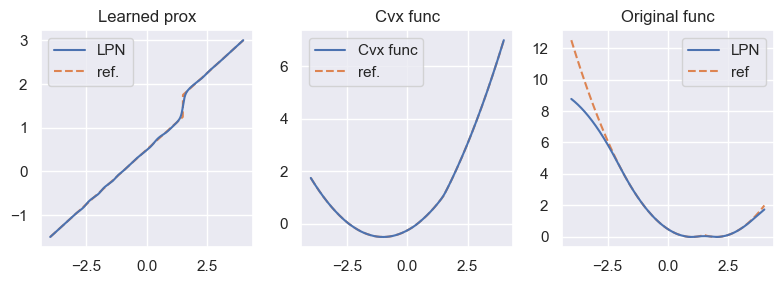

In [31]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 2.9289772510528564
iteration 0 loss 8.972185134887695
iteration 500 loss 0.6065491437911987
iteration 1000 loss 0.37400802969932556
iteration 1500 loss 0.13995248079299927
iteration 2000 loss 0.02427685260772705
iteration 2500 loss 0.008247826248407364
iteration 3000 loss 0.007162831258028746
iteration 3500 loss 0.0049603963270783424
iteration 4000 loss 0.004749774467200041
iteration 4500 loss 0.0058099087327718735
iteration 5000 loss 0.008066464215517044
iteration 5500 loss 0.0029737341683357954
iteration 6000 loss 0.003620624542236328
iteration 6500 loss 0.00254925899207592
iteration 7000 loss 0.0033514434471726418
iteration 7500 loss 0.0035859812051057816
iteration 8000 loss 0.0024794870987534523
iteration 8500 loss 0.003766912268474698
iteration 9000 loss 0.003313713939860463
iteration 9500 loss 0.003544925944879651
iteration 10000 loss 0.0033084258902817965
iteration 10500 loss 0.005293035879731178
iteration 11000 loss 0.0024451676290482283
iteration 11500 loss 0.

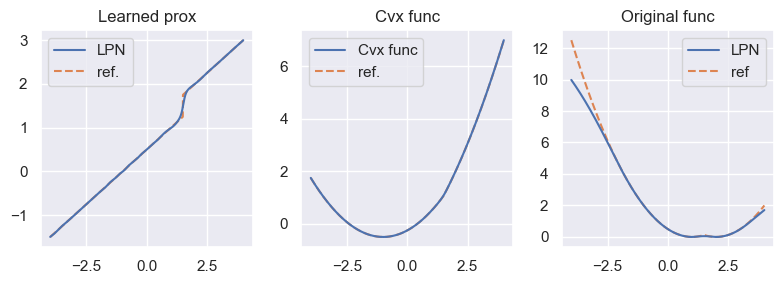

In [32]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=10

iteration 0 loss 0.07981645315885544
iteration 500 loss 0.0014483320992439985
iteration 1000 loss 0.0003659978392533958
iteration 1500 loss 0.0001449882984161377
iteration 2000 loss 6.067275899113156e-05
iteration 2500 loss 2.429932283121161e-05
iteration 0 loss 9.803175998968072e-06
iteration 500 loss 8.910000360629056e-06
iteration 1000 loss 7.908940460765734e-06
iteration 1500 loss 6.831288374087308e-06
iteration 2000 loss 5.714893177355407e-06
iteration 2500 loss 4.614591489371378e-06
mse 5.472487449645996
mse 4.1221137046813965
mse 2.1058666706085205
mse 1.453000783920288
mse 0.9689978957176208
mse 0.6518465280532837
mse 0.5771969556808472
mse 0.5356361269950867
mse 0.5070583820343018
mse 0.4935310482978821
final mse 0.4875113368034363
(1000,) (1000,) (1000,) (1000,)


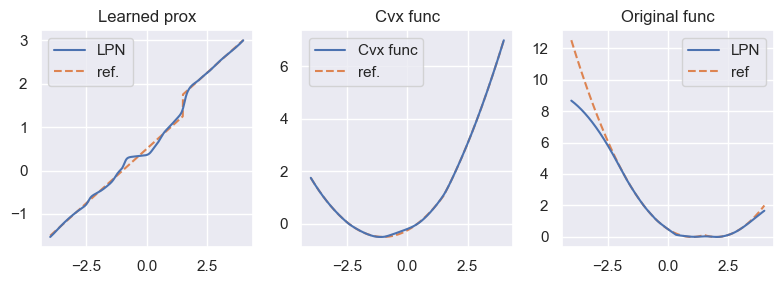

In [33]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 10

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=5

iteration 0 loss 1.4326572454592679e-05
iteration 500 loss 5.416572093963623e-06
iteration 1000 loss 2.297163064213237e-06
iteration 1500 loss 1.1149048759762081e-06
iteration 2000 loss 6.976723625484738e-07
iteration 2500 loss 4.932284127789899e-07
iteration 3000 loss 3.7372112160483084e-07
iteration 3500 loss 3.194809039541724e-07
iteration 4000 loss 2.843141544417449e-07
iteration 4500 loss 2.5302171025032294e-07
iteration 5000 loss 2.2590160142499371e-07
iteration 5500 loss 2.089142867589544e-07
mse 5.587430000305176
mse 3.857388496398926
mse 2.3385391235351562
mse 1.7153888940811157
mse 1.1807060241699219
mse 0.7824091911315918
mse 0.5362072587013245
mse 0.464973121881485
mse 0.43415141105651855
mse 0.41934582591056824
final mse 0.4125170409679413
(1000,) (1000,) (1000,) (1000,)


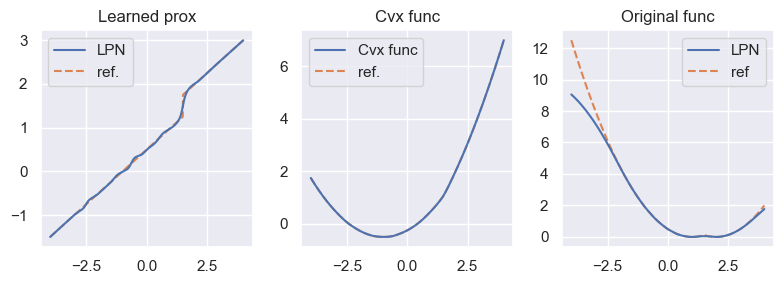

In [34]:
gamma_loss = 5

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(6000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=1

iteration 0 loss 4.885494490736164e-06
iteration 500 loss 4.6148898036335595e-06
iteration 1000 loss 4.351735242380528e-06
iteration 1500 loss 4.080831786268391e-06
iteration 2000 loss 3.795325710598263e-06
iteration 2500 loss 3.4943222999572754e-06
iteration 3000 loss 3.1691788535681553e-06
iteration 3500 loss 2.879202384065138e-06
iteration 4000 loss 2.716481731113163e-06
iteration 4500 loss 2.536773763495148e-06
iteration 5000 loss 2.3481250082113547e-06
iteration 5500 loss 2.2420288132707356e-06
iteration 6000 loss 2.1442770048452076e-06
iteration 6500 loss 2.0396710169734433e-06
iteration 7000 loss 1.927018274727743e-06
iteration 7500 loss 1.8686056364458636e-06
iteration 8000 loss 1.8161534853788908e-06
iteration 8500 loss 1.7568469274920062e-06
iteration 9000 loss 1.6909838223000406e-06
iteration 9500 loss 1.6474723452120088e-06
mse 5.598323345184326
mse 3.8968706130981445
mse 2.307163715362549
mse 1.6387959718704224
mse 1.1527247428894043
mse 0.7738199234008789
mse 0.5190073847

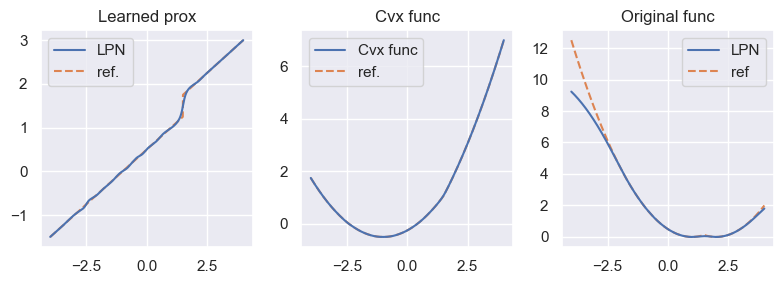

In [35]:
gamma_loss = 1

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)